# **Bitcoin Time Series Momentum Trading**

In [95]:
import pandas as pd
import altair as alt
import polars as pl
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from hmmlearn.hmm import GaussianHMM
from statsmodels.graphics.tsaplots import plot_acf

In [96]:
bitcoin = pl.read_csv("btcusd_1-min_data.csv")

bitcoin = bitcoin.with_columns(
    pl.from_epoch(pl.col("Timestamp"), time_unit="s").alias("Timestamp")
).rename({"Timestamp": "Date"})

print(bitcoin)

shape: (6_729_281, 6)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┬───────────┐
│ Date                ┆ Open     ┆ High     ┆ Low      ┆ Close    ┆ Volume    │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
│ datetime[μs]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╪═══════════╡
│ 2012-01-01 10:01:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:02:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:03:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:04:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:05:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ …                   ┆ …        ┆ …        ┆ …        ┆ …        ┆ …         │
│ 2024-12-15 23:57:00 ┆ 104510.0 ┆ 104510.0 ┆ 104257.0 ┆ 104268.0 ┆ 27.923539 │
│ 2024-12-15 23:58

In [97]:
print(bitcoin.null_count())

shape: (1, 6)
┌──────┬──────┬──────┬─────┬───────┬────────┐
│ Date ┆ Open ┆ High ┆ Low ┆ Close ┆ Volume │
│ ---  ┆ ---  ┆ ---  ┆ --- ┆ ---   ┆ ---    │
│ u32  ┆ u32  ┆ u32  ┆ u32 ┆ u32   ┆ u32    │
╞══════╪══════╪══════╪═════╪═══════╪════════╡
│ 1    ┆ 0    ┆ 0    ┆ 0   ┆ 0     ┆ 0      │
└──────┴──────┴──────┴─────┴───────┴────────┘


In [98]:
bitcoin = bitcoin.filter(
    pl.col("Date").is_not_null()
)

## **Exploratory Data Analysis**

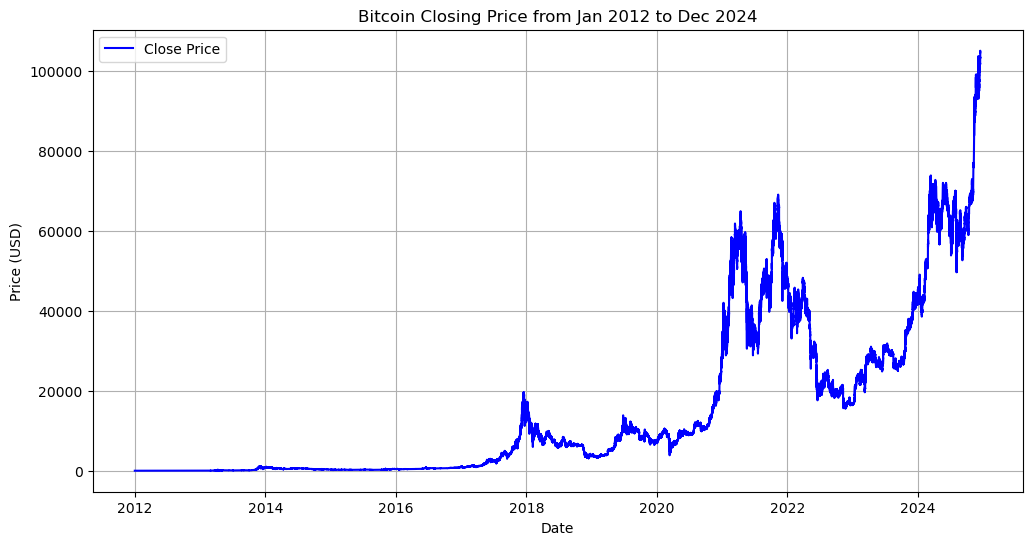

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin["Date"], bitcoin["Close"], label="Close Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Closing Price from Jan 2012 to Dec 2024")
plt.legend()
plt.grid()
plt.show()

In [100]:
def plot_daily_candlesticks(prices, start, end=None):
    prices_daily = prices.group_by(
        pl.col("Date").dt.date().alias("Day")
    ).agg([
        pl.col("Open").first().alias("Open"),
        pl.col("High").max().alias("High"),
        pl.col("Low").min().alias("Low"),
        pl.col("Close").last().alias("Close"),
        pl.col("Volume").sum().alias("Volume")
    ]).sort("Day")

    if end:
        prices_daily = prices_daily.filter(
            pl.col("Day") >= start,
            pl.col("Day") <= end
        )
    else:
        prices_daily = prices_daily.filter(
            pl.col("Day") >= start
        )

    if prices_daily.is_empty():
        print("No data available for the specified date range.")
        return

    fig = make_subplots(
        rows=2, cols=1, shared_xaxes=True, 
        row_heights=[0.65, 0.35],  
        vertical_spacing=0.08, 
    )

    fig.add_trace(
        go.Candlestick(
            x=prices_daily.select('Day').to_series(),
            open=prices_daily.select('Open').to_series(),
            high=prices_daily.select('High').to_series(),
            low=prices_daily.select('Low').to_series(),
            close=prices_daily.select('Close').to_series()
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(
            x=prices_daily.select('Day').to_series(),
            y=prices_daily.select('Volume').to_series(),
            marker_color="gray"
        ),
        row=2, col=1
    )

    min_date = prices_daily["Day"].min()
    max_date = prices_daily["Day"].max()
    
    fig.update_layout(
        title_text=f"Bitcoin Daily OHLC and Volume Chart from {min_date} to {max_date}",
        yaxis_title="Price (USD)",
        xaxis2_title="Date",
        yaxis2_title="Volume",
        template="plotly_dark",
        width=1000, height=500,
        xaxis_rangeslider_visible=False,
        showlegend=False,
    )

    fig.show()

plot_daily_candlesticks(bitcoin, datetime(2024, 1, 1))
plot_daily_candlesticks(bitcoin, datetime(2021, 1,1), datetime(2022, 1, 1))

Here we cna see that large large drops in prices are often associated with spikes in volume which emphasize the fear of large drops.

### **Log Returns**

In [101]:
# Compute 1-min Log returns
bitcoin = bitcoin.with_columns(
    (pl.col("Close") / pl.col("Close").shift(1)).log().alias("Log returns")
).filter(
    pl.col("Log returns").is_not_null()
)

# Compute Daily Log returns
log_returns_daily = bitcoin.group_by(
    pl.col("Date").dt.date()
).agg([
    pl.col("Log returns").sum()
]).sort("Date")

# Compute descriptive statistics
desc_1min = bitcoin.select("Log returns").describe()
desc_daily = log_returns_daily.select("Log returns").describe()

combined_desc = pl.concat(
    [
        desc_1min.select("statistic"),
        desc_1min.select("Log returns").rename({"Log returns": "1-min Log Returns"}),
        desc_daily.select("Log returns").rename({"Log returns": "Daily Log Returns"})
    ],
    how="horizontal"
)
print(combined_desc)

shape: (9, 3)
┌────────────┬───────────────────┬───────────────────┐
│ statistic  ┆ 1-min Log Returns ┆ Daily Log Returns │
│ ---        ┆ ---               ┆ ---               │
│ str        ┆ f64               ┆ f64               │
╞════════════╪═══════════════════╪═══════════════════╡
│ count      ┆ 6.729279e6        ┆ 4734.0            │
│ null_count ┆ 0.0               ┆ 0.0               │
│ mean       ┆ 0.000001          ┆ 0.00212           │
│ std        ┆ 0.001853          ┆ 0.042833          │
│ min        ┆ -0.617058         ┆ -0.773023         │
│ 25%        ┆ -0.000234         ┆ -0.012386         │
│ 50%        ┆ 0.0               ┆ 0.001556          │
│ 75%        ┆ 0.000246          ┆ 0.018091          │
│ max        ┆ 0.616914          ┆ 0.306092          │
└────────────┴───────────────────┴───────────────────┘


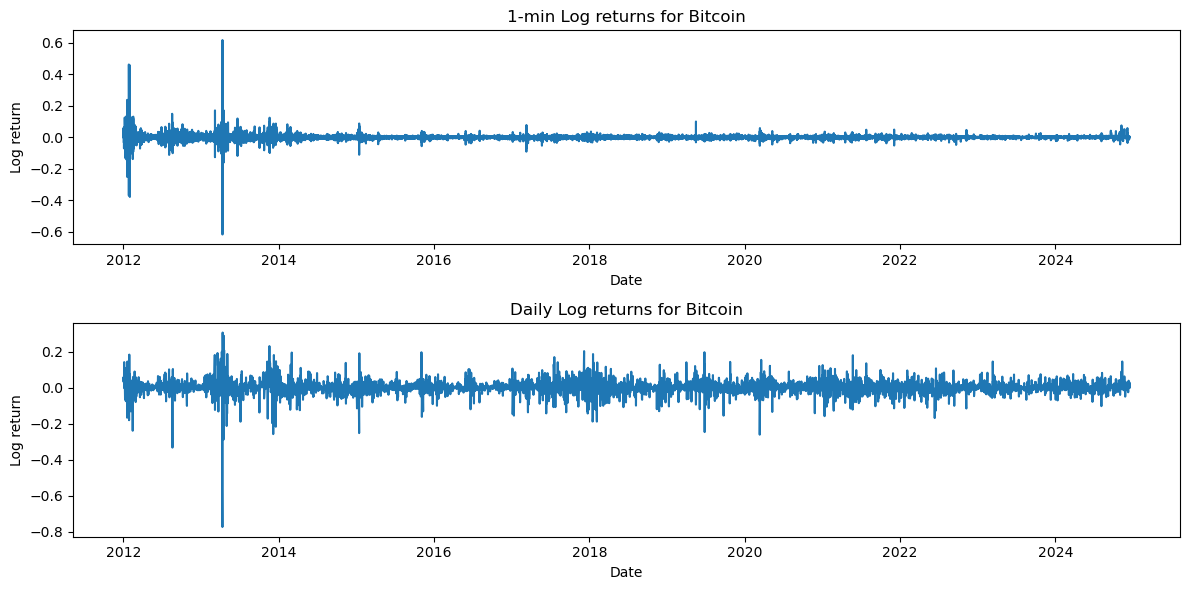

In [102]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].plot(bitcoin.select("Date"), bitcoin.select("Log returns"))
axes[0].set_title("1-min Log returns for Bitcoin")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Log return")

axes[1].plot(log_returns_daily.select("Date"), log_returns_daily.select("Log returns"))
axes[1].set_title("Daily Log returns for Bitcoin")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Log return")

plt.tight_layout()
plt.show()

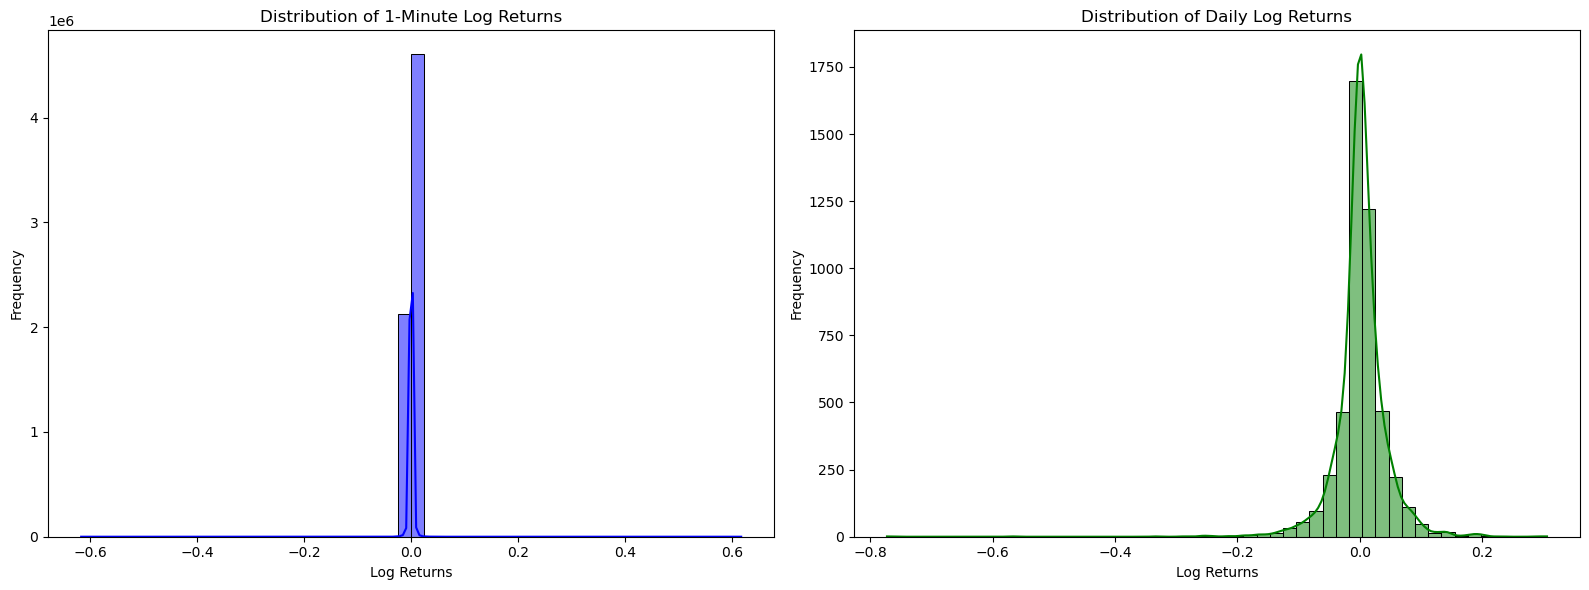

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram 1-min log returns
sns.histplot(
    bitcoin.select("Log returns").to_series(),
    kde=True, bins=50, color="blue", ax=axes[0]
)
axes[0].set_title("Distribution of 1-Minute Log Returns")
axes[0].set_xlabel("Log Returns")
axes[0].set_ylabel("Frequency")

# Histogram Daily log returns
sns.histplot(
    log_returns_daily.select("Log returns").to_series(),
    kde=True, bins=50, color="green", ax=axes[1]
)
axes[1].set_title("Distribution of Daily Log Returns")
axes[1].set_xlabel("Log Returns")
axes[1].set_ylabel("Frequency")

fig.tight_layout()
plt.show()

Because of extreme -6% and 6% returns, the distribution shape for 1-min returns is concentrated around 0, while for daily returns despite observing some -7% returns the dsitribution is more spread out. Thus for 1-min log returns it might be reasonable to address trye extreme observations as we don't want our models to predict them.

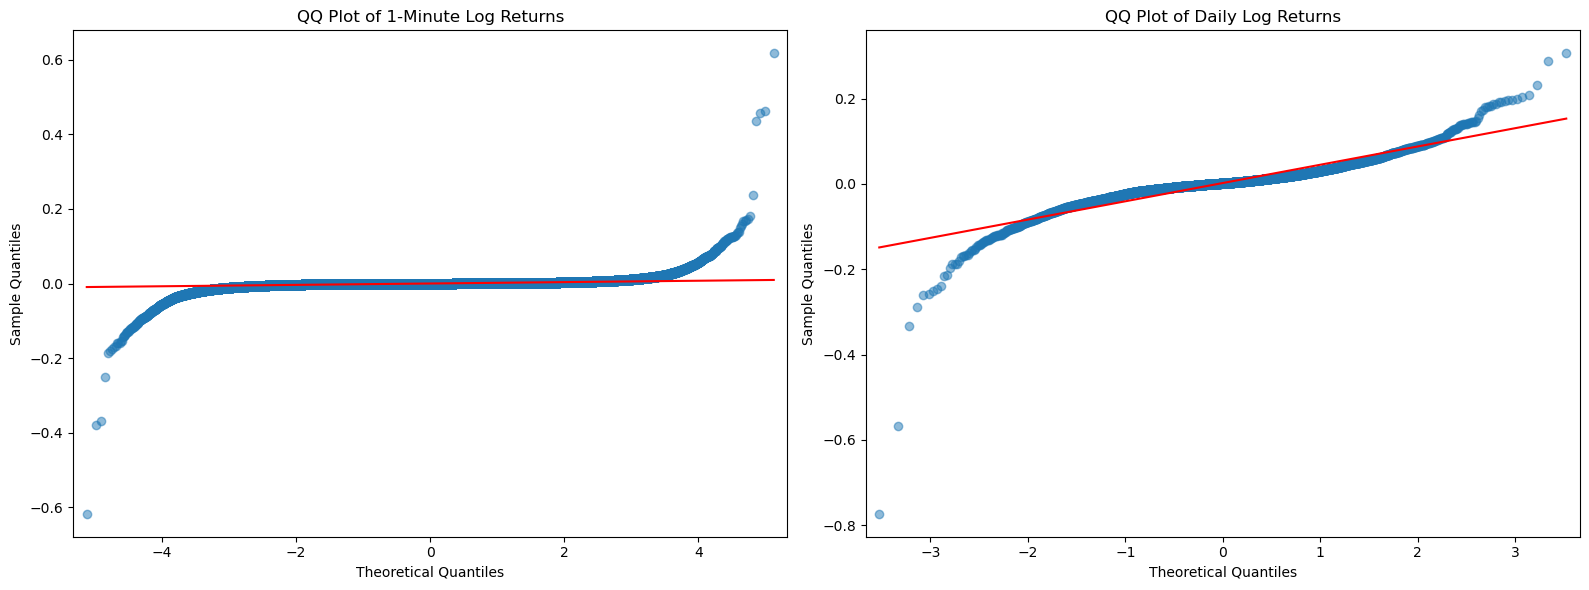

In [104]:
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# QQ Plot 1-Minute Log Returns
qqplot(bitcoin.select("Log returns").to_series(), line="s", ax=axes[0], alpha=0.5)
axes[0].set_title("QQ Plot of 1-Minute Log Returns")
axes[0].set_xlabel("Theoretical Quantiles")
axes[0].set_ylabel("Sample Quantiles")

# QQ Plot Daily Log Returns
qqplot(log_returns_daily.select("Log returns").to_series(), line="s", ax=axes[1], alpha=0.5)
axes[1].set_title("QQ Plot of Daily Log Returns")
axes[1].set_xlabel("Theoretical Quantiles")
axes[1].set_ylabel("Sample Quantiles")

fig.tight_layout()
plt.show()

It is obvious with the QQ plots that the returns outside of the range (-2%,2%) can be considered as outliers and be removed safely

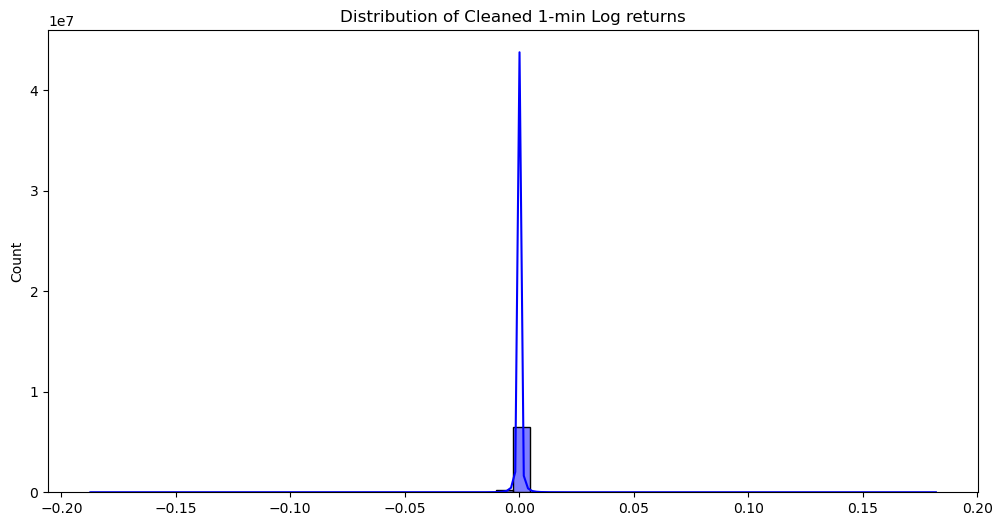

In [105]:
# Define return thresholds based on visual analysis of QQ plot
lower_bound = -0.2  
upper_bound = 0.2

bitcoin = bitcoin.filter(
    (pl.col("Log returns") >= lower_bound) & (pl.col("Log returns") <= upper_bound)
)

plt.figure(figsize=(12, 6))
sns.histplot(
    bitcoin.select("Log returns").to_series(),
    kde=True, bins=50, color="blue"
)
plt.title("Distribution of Cleaned 1-min Log returns")
plt.show()

Despite removing extreme returns the distribution is still widely spread out, so it may be necessary to address the remaining outlier with a more powerful outlier handling technique. For that we are goign to use a **winsorization**.

In [106]:
def winsorize(df, col_name, thresholds):
    """
    Winsorizes a column in a Polars DataFrame for multiple thresholds.

    Args:
        df (pl.DataFrame): The Polars DataFrame containing the column to winsorize.
        col_name (str): The name of the column to winsorize.
        thresholds (list of tuples): List of (lower_percentile, upper_percentile) tuples.

    Returns:
        pl.DataFrame: A new DataFrame with additional winsorized columns.
    """
    for lower_percentile, upper_percentile in thresholds:
        lower_bound = df.select(pl.col(col_name).quantile(lower_percentile))[0, 0]
        upper_bound = df.select(pl.col(col_name).quantile(upper_percentile))[0, 0]
        
        df = df.with_columns(
            pl.col(col_name).clip(lower_bound, upper_bound).alias(
                f"{col_name} winsorized {int(lower_percentile*100)}-{int(upper_percentile*100)}%"
            )
        )
    return df

thresholds = [(0.10, 0.90), (0.05, 0.95), (0.01, 0.99), (0.005, 0.995)]
bitcoin = winsorize(bitcoin, "Log returns", thresholds)
print(bitcoin)

shape: (6_729_270, 11)
┌────────────┬──────────┬──────────┬──────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Date       ┆ Open     ┆ High     ┆ Low      ┆ … ┆ Log        ┆ Log       ┆ Log       ┆ Log       │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆   ┆ returns    ┆ returns   ┆ returns   ┆ returns   │
│ datetime[μ ┆ f64      ┆ f64      ┆ f64      ┆   ┆ winsorized ┆ winsorize ┆ winsorize ┆ winsorize │
│ s]         ┆          ┆          ┆          ┆   ┆ 10-90%     ┆ d 5-95%   ┆ d 1-99%   ┆ d 0-99%   │
│            ┆          ┆          ┆          ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│            ┆          ┆          ┆          ┆   ┆ f64        ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪══════════╪══════════╪══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 2012-01-01 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ … ┆ 0.0        ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 10:02:00   ┆          ┆          ┆          ┆   ┆            ┆    

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(
    bitcoin.select("Log returns winsorized").to_series(),
    kde=True, bins=50, color="blue"
)
plt.title("Distribution of Winsorized 1-min Log returns")
plt.show()

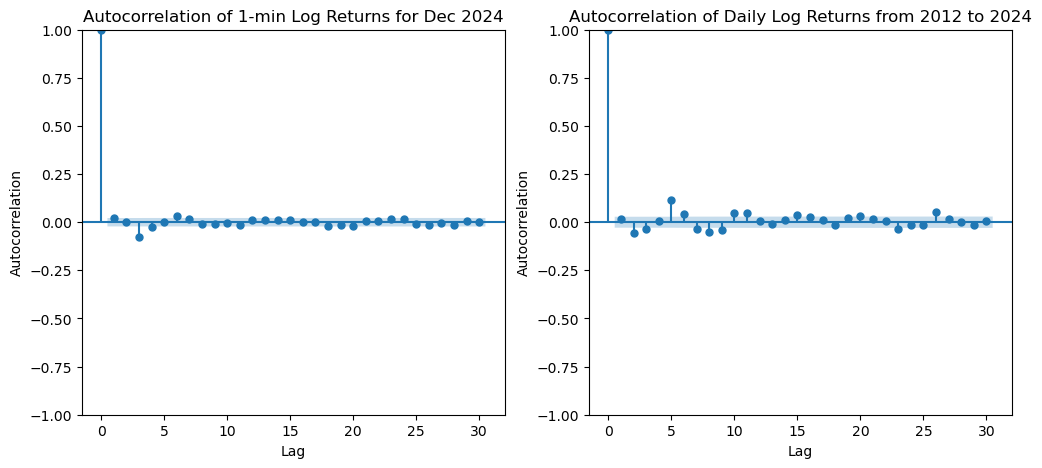

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(bitcoin.filter(
    pl.col("Date") >= datetime(2024, 12, 1)
    ).select("Log returns"), 
    lags=30, ax=axes[0])
axes[0].set_title("Autocorrelation of 1-min Log Returns for Dec 2024")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")

plot_acf(log_returns_daily.select("Log returns"), lags=30, ax=axes[1])
axes[1].set_title("Autocorrelation of Daily Log Returns")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Autocorrelation")

plt.show()

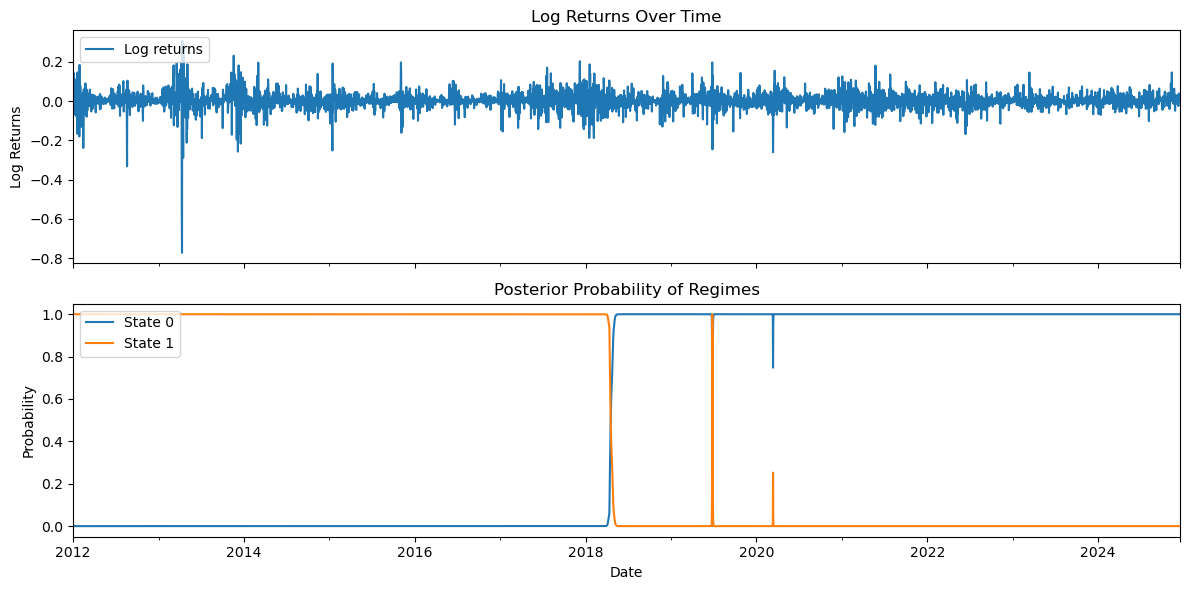

In [116]:
# Train HMM
n_states = 2  # High and low volatility
model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100)
model.fit(log_returns_daily)
posterior_probs = model.predict_proba(log_returns_daily)

posterior_probs = pd.DataFrame(
    posterior_probs, 
    index=log_returns_daily.select("Date").to_series(),
    columns=["State 0","State 1"]
)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(log_returns_daily.select("Date"), log_returns_daily.select("Log returns"), label="Log returns")
axes[0].set_title("Log Returns Over Time")
axes[0].set_ylabel("Log Returns")
axes[0].legend(loc="upper left")

posterior_probs.plot(ax=axes[1])
axes[1].set_title("Posterior Probability of Regimes")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Probability")
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

In [124]:
bitcoin_2024 = bitcoin.lazy().with_columns(
    (pl.col("Close") - pl.col("Open")).alias("Daily Change")
).filter(
    pl.col("Date") >= datetime(2022, 1, 1)
).collect()
bitcoin_2024

0.0050868988037109375


### **Long Short Term Memory (LSTM)**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.base import BaseEstimator, RegressorMixin

class LSTMModel(nn.Module):
    def __init__(self, n_units=50, input_size=1, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, n_units, batch_first=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
        self.fc = nn.Linear(n_units, 1)

    def forward(self, x):
        out, _ = self.lstm(x)  # out: (batch, timesteps, n_units)
        out = out[:, -1, :]    # Take the last timestep's output
        if self.dropout:
            out = self.dropout(out)
        out = self.fc(out)     # (batch, 1)
        return out

class LSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 learning_rate=0.01,
                 n_units=50,
                 dropout=0.0,
                 loss='mse',
                 epochs=10,
                 batch_size=32,
                 verbose=0,
                 patience=3,
                 seq_len=10,
                 n_workers=0,
                 device=None):
        self.learning_rate = learning_rate
        self.n_units = n_units
        self.dropout = dropout
        self.loss = loss
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.patience = patience
        self.seq_len = seq_len
        self.n_workers = n_workers
        self.is_sequence_model = True

        if device is None:
            if torch.backends.mps.is_available():
                self.device = torch.device("mps")
            elif torch.cuda.is_available():
                self.device = torch.device("cuda")
            else:
                self.device = torch.device("cpu")
        else:
            self.device = torch.device(device)

        self.model_ = None

    def _get_loss_function(self):
        if self.loss == 'mse':
            return nn.MSELoss()
        elif self.loss == 'mae':
            return nn.L1Loss()
        else:
            raise ValueError(f"Unsupported loss: {self.loss}")

    def _create_sequences(self, X, y=None):
        N, _ = X.shape
        if N <= self.seq_len:
            raise ValueError("Number of observations must be greater than seq_len.")

        X_seq = []
        if y is not None:
            y_seq = []

        for i in range(N - self.seq_len):
            X_seq.append(X[i:i+self.seq_len, :])
            if y is not None:
                y_seq.append(y[i+self.seq_len])

        X_seq = np.array(X_seq, dtype=np.float32)
        if y is not None:
            y_seq = np.array(y_seq, dtype=np.float32)
            return X_seq, y_seq
        return X_seq

    def build_model(self, input_size):
        model = LSTMModel(n_units=self.n_units, input_size=input_size, dropout=self.dropout)
        return model.to(self.device)

    def fit(self, X_train, y_train):
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.values
        if isinstance(y_train, (pd.Series, pd.DataFrame)):
            y_train = y_train.values.ravel()  # ensure 1D array

        X_train_seq, y_train_seq = self._create_sequences(X_train, y_train)

        # Create tensors directly on the target device
        X_train_t = torch.tensor(X_train_seq, dtype=torch.float32, device=self.device)
        y_train_t = torch.tensor(y_train_seq, dtype=torch.float32, device=self.device).unsqueeze(-1)

        _, _, input_size = X_train_seq.shape

        if self.model_ is None:
            self.model_ = self.build_model(input_size)

        dataset = TensorDataset(X_train_t, y_train_t)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, num_workers=self.n_workers)

        optimizer = Adam(self.model_.parameters(), lr=self.learning_rate)
        criterion = self._get_loss_function()

        best_loss = np.inf
        epochs_no_improve = 0

        for epoch in range(self.epochs):
            self.model_.train()
            epoch_loss = 0.0
            for X_batch, y_batch in dataloader:
                optimizer.zero_grad()
                preds = self.model_(X_batch)
                loss_val = criterion(preds, y_batch)
                loss_val.backward()
                optimizer.step()
                epoch_loss += loss_val.item() * X_batch.size(0)

            epoch_loss /= len(dataset)
            if self.verbose:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")

            # Early stopping
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    if self.verbose:
                        print("Early stopping triggered.")
                    break

        return self

    def predict(self, X_test):
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.values

        X_test_seq = self._create_sequences(X_test)

        self.model_.eval()
        with torch.no_grad():
            X_test_t = torch.tensor(X_test_seq, dtype=torch.float32, device=self.device)
            preds = self.model_(X_test_t)
            return preds.cpu().numpy().ravel()

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        # If model parameters changed in a way that requires rebuilding the model:
        self.model_ = None
        return self

    def get_params(self, deep=True):
        return {
            'learning_rate': self.learning_rate,
            'n_units': self.n_units,
            'dropout': self.dropout,
            'loss': self.loss,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose,
            'patience': self.patience,
            'seq_len': self.seq_len,
            'device': self.device.type if isinstance(self.device, torch.device) else self.device
        }


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = ['wind_boxcox', 'load']

X_train[scaled_features] = scaler.fit_transform(X_train[scaled_features])

X_val = val[X_train.columns]
y_val = val[target]
X_test = test[X_train.columns]
y_test = test[target]

X_val[scaled_features] = scaler.transform(X_val[scaled_features])
X_test[scaled_features] = scaler.transform(X_test[scaled_features])
lstm_params = {
    "learning_rate": [0.005, 0.01, 0.05],
    "n_units": [32, 50, 100],
    "dropout": [0.0, 0.1, 0.2]
}

lstm_model = LSTMRegressor(device="cpu", batch_size=64, seq_len=21, learning_rate=0.05)

lstm_best_params = hyperparameter_tuning(
    lstm_model,
    lstm_params,
    X_train,
    y_train,
    X_val,
    y_val,
    imbalances_val,
    val["spread"]
)

results_lstm = evaluate_model(
    lstm_model, lstm_best_params[0], 
    X_train, y_train, X_val, y_val, X_test, y_test, 
    imbalances_test, test["spread"]
)

print(f"Cumulated PnL: {results_lstm['pnl_cumsum'].iloc[-1]:,.2f}€")
results_lstm['pnl_cumsum'].plot(figsize=(12, 6))